# IEX Trading

## IEX Stocks

In the [previous notebook](./IEX_trading.ipynb), we saw how all the trades on the IEX stock exchange could be interactively visualized over the course of a whole day (Monday 21st of October 2019). Using datashader, all the trades are rasterized interactively to reveal the density of trades via a colormap.

When viewing a million trades at once for a whole day, it is extremely difficult to identify individual trades using a global view. In order to identify particular trades, it is necessary to zoom into a time window small enough that individual trades can be distinguished at which point the trade metadata can be inspected using the Bokeh hover tool. What the global visualization helps reveal is the overall pattern of trades. In this notebook, we will focus on interactively revealing the trading patterns for individual stocks by partitioning on a set of stock symbols selected with a widget.

To achieve this, we will use the following Python packages:
- [Pandas](https://pandas.pydata.org/): Used for data manipulation and analysis
- [Datashader](https://datashader.org/): Aggregates big datasets into a fixed-sized array suitable for display in the browser
- [HoloViews](https://holoviews.org/): Flexibly combines each of the data sources into a just-in-time displayale, interactive plot
- [Bokeh](https://docs.bokeh.org/): Generate JavaScript-based interactive plot from HoloViews declarative specification
- [Panel](https://panel.holoviz.org/): Creates interactive dashboards to allow the data to be more easily exploredidget.

![image](./thumbnails/iex_stocks_thumbnail.png)

## Loading the data

First, we will load the data as before, converting the integer timestamps into the correctly offset datetimes before counting the total number f events:

In [3]:
import datetime
import pandas as pd
df = pd.read_csv('./data/IEX_2019-10-21.csv')
df.timestamp = df.timestamp.astype('datetime64[ns]')
df.timestamp -= datetime.timedelta(hours=4)
print('Dataframe loaded containing %d events' % len(df))

Dataframe loaded containing 12224 events


Next we will identify the top ten most traded stocks on this day and compute how much of the trading volume (i.e summed over the `size` column) that they account for:

In [4]:
symbol_volumes = df.groupby('symbol')['size'].sum()
top_symbol_volumes = symbol_volumes.sort_values()[-10:]
top_symbols = ', '.join(list(top_symbol_volumes.index))
top_volume_percent = top_symbol_volumes.sum() / symbol_volumes.sum() * 100

top_symbol_info = f"The top ten symbols are {top_symbols} and account for {top_volume_percent:.2f}% of trading volume"
top_symbol_info

'The top ten symbols are AY, ARNC, TEVA, SGEN, CMCSA, HPE, BAC, TJX, ERIC, INFY and account for 11.41% of trading volume'

The following dictionary below show the names of the companies that each of these ten symbols correspond to:

In [5]:
symbol_info = {
    "PInterest":'PINS',
    'Chesapeake Energy Corporation': 'CHK',
    "Snap Inc": 'SNAP',
    "NIO Inc": 'NIO',
    "McDermott International": 'MDR',
    "Teva Pharmaceutical Industries": 'TEVA',
    "Hewlett Packard Enterprise":'HPE',
    "Bank of America": 'BAC',
    "GE": 'General Electric',
    "Infosys":'INFY',
    }

Before we can visualize each of these stocks individually, we will need
to import the necessary libraries:

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
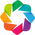

In [22]:
import holoviews as hv
from bokeh.models import HoverTool
import datashader as ds

from holoviews.operation.datashader import spikes_aggregate
hv.config.image_rtol = 10e-3 # Suppresses datetime issue at high zoom level
hv.extension('bokeh')

## Visualizing trade volume by stock

As in the [previous notebook](./IEX_trading.ipynb), we will create a `Spikes` element containing our entire dataset. Instead of immediately rasterizing it, we will be selecting individual stocks from it and rasterizing those components individually.

**Note**: *If you display the `spikes` object at this time, it will probably freeze or crash your browser tb!*


In [23]:
spikes = hv.Spikes(df, ['timestamp'], ['symbol', 'size', 'price'])

### Visualizing two stocks at once

In order to understand how to build a fairly complex, interactive visualization, it is useful to build a simple prototype to identify the necessary concepts and decide whether it will satisfy our goals. In this section, we will prototype a fixed view that will let us directly compare the trading patterns for the top two stocks (PINS and CHK).

We start by defining some options called `raster_opts` used to customize the rasterized output of the `visualize_symbol_raster` function. We will use the `responsive=True` option to make our rasters fill the scren:


In [24]:
raster_opts = hv.opts.Image(min_height=400, responsive=True,
                            colorbar=True, cmap='blues', xrotation=90,
                            default_tools=['xwheel_zoom', 'xpan', 'xbox_zoom'])

def visualize_symbol_raster(symbol, offset):
    selection = spikes.select(symbol=symbol)
    return spikes_aggregate(selection, offset=offset,
                            aggregator=ds.sum('size'),
                            spike_length=1).opts(raster_opts)

In the `visualize_symbol_raster` function, the `.select` method on our `spikes` object is used to select only the spikes that match the symbol specified in the argument. This function also takes an integer `offset` argument that offsets the rasterized `Image` vertically by one unit (the spikes are unit length as specified with `spike_length=1`).

One other difference from the previous notebook is that now a datashader aggregator over the `'size'` column is used in order to visualize the trade volume as opposed to the trade count.

Now we can use this function with our two chosen stock symbols (PINS and CHK) to create an overlay. Lastly, we want to use the y-axis to label these stocks so we use a custom `yticks` option and set the `ylabl`.


In [12]:
overlay = visualize_symbol_raster('PINS', 0) * visualize_symbol_raster('CHK', 1)
overlay.opts(yticks=[(0.5, 'PINS'), (1.5, 'CHK')], ylabel='Stock Symbol')

:DynamicMap   []
   :Overlay
      .Image.I  :Image   [timestamp,y]   (timestamp_y size)
      .Image.II :Image   [timestamp,y]   (timestamp_y size)

We now want to generalize this example in the following ways:

1. We wish to choose from any of the top ten stocks with a widget.
2. We want to reveal the stock metadata with the Bokeh hover tool in the same way as the [previous notebook](./IEX_trading.ipynb).

The next section will demonstrate one way this can be done.

## Visualizing the top stocks interactively

Our prototype is generalized in three steps:

1. First, the hover behavior is reintroduced per symbol.
2. Next, the process of overlaying the visualizations for the different symbols is generalized.
3. Finally, `panel` is used to add an interactive widget to select from the top ten stocks.

### Adding interactive hover for metadata

To enable the desired hover behavior, we shall create a custom Bokeh hover tool that formats the 'Symbol', 'Price', and 'Timestamp' columns of the dataframe nicely. In addition, a simple `RangeX` seam is declared:


In [13]:
hover = HoverTool(tooltips=[
    ('Symbol', '@symbol'),
    ('Size', '@size'),
    ('Price', '@price'),
    ('Timestamp', '@timestamp{%F %H:%M %Ss %3Nms}')],
                  formatters={'timestamp': 'datetime'})

range_stream = hv.streams.RangeX()

Note that in this instance, the `source` of the `RangeX` stream is not defined upon construction: we will be setting it dynamically later. The `xrange_filter` function, however, is the same as the previous notebook (with the number of allowed hover spikes lowered to 200):

In [14]:
def xrange_filter(spikes, x_range):
    low, high = (None, None) if x_range is None else x_range
    ranged = spikes[pd.to_datetime(low):pd.to_datetime(high)]
    return (ranged if len(ranged) < 200 else ranged.iloc[:0]).opts(spike_length=1, alpha=0)

The next function, `visualize_symbol`, builds on the approach used in `visualize_symbol_raster` above by overlaying each raster with the appropriate x-range filtered (invisible) `Spikes` in order to enable hovering.

This is done using the same approach as the [previous notebook](./IEX_trading.ipynb), where we use the `apply` method on the spikes to apply the `xrange_filter` function. Note that as the `symbol` argument changes, the `Spikes` object returned by the `select` method also changes. This is why we need to set the `source` on our stream dynamically.

In addition, to keep everything consistent, we want to use our single `range_stream` everywhere, including in the `DynamicMap` returned by `spikes_aggregate`. This is done by passing `range_stream` explicitly in the `streams` argument. This approach of using a single `RangeX` and setting the `source` ensures that you can zoom in and then select a different set of stocks to be displayed without resetting the zoom level.

Lastly, we need to pass `expand=False` to prevent datashader from filling the whole y-range (with NaN colors where there is no data) for each raster genated.


In [15]:
def visualize_symbol(symbol, offset):
    selection = spikes.select(symbol=symbol)
    range_stream.source = selection
    rasterized = spikes_aggregate(selection, streams=[range_stream],
                                  offset=offset, expand=False,
                                  aggregator=ds.sum('size'),
                                  spike_length=1).opts(raster_opts)
    filtered = selection.apply(xrange_filter, streams=[range_stream])
    return rasterized * filtered.opts(tools=[hover], position=offset)

This `visualize_symbol` function simply adds hover behavior to `visualize_symbol_raster`: you can now use the former to visualize the PINS and CHK stocks in exactly the same way as was demonstrated above.

### Building a dynamic overlay of stocks

The following `overlay_symbols` function is a trivial generalization of the prototype that overlays an arbitrary list of stocks according to their symbols. Each `DynamicMap` returned by `visualize_symbol` is collected into an `Overlay` and the corresponding `yticks` plot option is dynamically generated.

The only new concept is the call to `.collate()` which is necessary convert an `Overlay` container of `DynamicMaps` into a `DynamicMap` of `Overlays` as required by the supported [nesting hierarchy](https://holoviews.org/user_guide/Building_Composite_Objects.html).

In [16]:
def overlay_symbols(symbols):
    items = []
    for offset, symbol in enumerate(symbols):
        items.append(visualize_symbol(symbol, offset))
    yticks = [(i+0.5,sym) for i,sym in enumerate(symbols)]
    return hv.Overlay(items).collate().opts(
        yticks=yticks).redim(y='Stock Symbol')

The prototype example could now be replicated (with hover) by calling `overlay_symbols(['PINS', 'CHK'])`.

### Adding a selector widget with `Panel`

Using the [Panel library](https://panel.holoviz.org/) we can easily declare a cross-selector widget specified with the `symbol_info` dictionary, with our two top stocks selected by default:

In [17]:
import panel as pn
cross_selector = pn.widgets.CrossSelector(options=symbol_info,
                                          sizing_mode='stretch_width',
                                          value=['PINS','CHK'])

Now we will use `pn.bind` to dynamically update our `overlay_symbols()` function based on the cross_selector's values. Then we will display both widgets in a panel `Column`:

In [18]:
overlay = pn.bind(overlay_symbols, symbols=cross_selector.param.value)
stock_selector = pn.Column(cross_selector, overlay)
stock_selector

Column
    [0] CrossSelector(options={'PInterest': 'PINS', ...}, sizing_mode='stretch_width', value=['PINS', 'CHK'])
    [1] ParamFunction(function, _pane=HoloViews, defer_load=False)

We now have a handle called `stock_selector` on a visualization that allows you to zoom in to any time during the day and view the metadata for the selected stocks (once sufficiently zoomed in).

As a final step, we can build a small dashboard by adding the IEX logo and a short Markdown description to `stock_selector` and declaring it `servable`().


In [19]:
dashboard_info = ('This dashboard allows exploration of the top ten stocks by volume '
                  'on the [IEX exchange](https://iextrading.com/) on Monday 21st '
                  'of October 2019. To view the metadata of individual trades, '
                  'enable the Bokeh hover tool and zoom in until you can '
                  'view individual trades.')
pn.Column(
    pn.pane.SVG('./assets/IEX_Group_Logo.svg', width=100),
    dashboard_info, stock_selector).servable()

Column
    [0] SVG(str, width=100)
    [1] Markdown(str)
    [2] Column
        [0] CrossSelector(options={'PInterest': 'PINS', ...}, sizing_mode='stretch_width', value=['PINS', 'CHK'])
        [1] ParamFunction(function, _pane=HoloViews, defer_load=False)

This dashboard can now be served using `panel serve IEX_stock.ipynb`.

### Conclusion

In this notebook, we have seen how a trade-by-trade stock explorer for arbitrarily large datasets can be built up incrementally using three of the [HoloViews](https://holoviews.org) tools, namely by using the HoloViews, Datashader API, and Panel for the widgets.